## Plot the predictions labels from validation

In [ ]:
from ultralytics.utils.plotting import plot_images
import numpy as np
import cv2

# 1. Lade dein Bild
image = cv2.imread('/home/heizung1/ultralytics_yolov8-obb_ob_kitti/ultralytics/cfg/datasets/kitti/images/val/bev_val_000006.png')
# BGR zu RGB konvertieren und in Format [C, H, W] bringen
image = image[..., ::-1].transpose(2, 0, 1)  # HWC -> CHW und BGR -> RGB
image = np.ascontiguousarray(image) / 255.0  # Normalisieren auf [0-1]
image = image[np.newaxis]  # Füge Batch-Dimension hinzu [1, C, H, W]

# 2. Deine Labels im Format [class_id, x, y, w, h, r]
prediction_path = '/home/heizung1/ultralytics_yolov8-obb_ob_kitti/runs/obb/val_trt_fp32/labels/bev_val_000006.txt'
predictions = []

with open(prediction_path, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            # Format: class_id x y w h r confidence
            parts = line.split()
            if len(parts) >= 7:  # Stellen wir sicher, dass alle Werte vorhanden sind
                class_id = int(float(parts[0]))
                x = float(parts[1])
                y = float(parts[2])
                w = float(parts[3])
                h = float(parts[4])
                r = float(parts[5])
                conf = float(parts[6])
                predictions.append([class_id, x, y, w, h, r, conf])

predictions = np.array(predictions)

# Extrahiere Klassen, Bounding Boxes und Confidence-Werte
classes = predictions[:, 0]
boxes = predictions[:, 1:6]  # [x, y, w, h, r]
confs = predictions[:, 6]

# Erstelle batch_idx (alle zum ersten Bild im Batch)
batch_idx = np.zeros(len(classes))

# Confidence-Werte (optional)
confs = np.ones(len(classes))

# 3. Plotte das Ergebnis
result = plot_images(
    images=image,
    batch_idx=batch_idx,
    cls=classes,
    bboxes=boxes,  # Format x,y,w,h,r wird automatisch erkannt durch die Form (da 5 Werte)
    confs=confs,
    fname="rotated_boxes.jpg",
    names={1: 'Car', 2: 'Ped', 3: 'Cyc'},  # Klassen-Namen
    save=True,
    show_corner_points=False
)

#from IPython.display import Image
#Image(filename="/home/heizung1/ultralytics_yolov8-obb_ob_kitti/ultralytics/rotated_boxes.jpg")

Exception in thread Thread-6 (plot_images):
Traceback (most recent call last):
  File "/home/heizung1/anaconda3/envs/ultralytics/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/heizung1/anaconda3/envs/ultralytics/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/heizung1/anaconda3/envs/ultralytics/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/home/heizung1/ultralytics_yolov8-obb_ob_kitti/ultralytics/utils/plotting.py", line 1122, in plot_images
    annotator.rectangle([x, y, x + w, y + h], None, (255, 255, 255), width=2)  # borders
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/heizung1/ultralytics_yolov8-obb_ob_kitti/ultralytics/utils/plotting.py", line 524, in rectangle
    self.draw.rectangle(xy, fill, outline, width)
    ^^^^^^^^^
AttributeError: 'Annotator' object ha

## Ultralytics Code suggestion for drawing the predictions

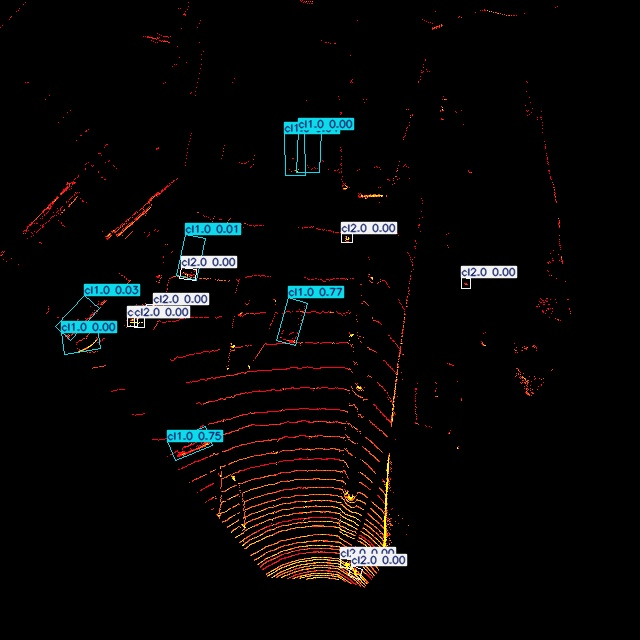

In [11]:
import cv2
import numpy as np
from ultralytics.utils.plotting import Annotator, colors

def draw_xywhr_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    ann = Annotator(image, line_width=1)

    predictions = []
    with open(label_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                if len(parts) >= 7:
                    predictions.append([float(x) for x in parts])
    
    for result in predictions:
        cls, x_center, y_center, width, height, rotation, conf = result
        
        # Convert xywhr to 4-point format
        cos_r, sin_r = np.cos(rotation), np.sin(rotation)
        corners = np.array([
            [-width/2, -height/2], [width/2, -height/2],
            [width/2, height/2], [-width/2, height/2]
        ])
        
        # Rotate and translate
        rot_matrix = np.array([[cos_r, -sin_r], [sin_r, cos_r]])
        rotated_corners = corners @ rot_matrix.T
        final_corners = rotated_corners + [x_center, y_center]
        
        label = f"cl{cls} {conf:.2f}"
        ann.box_label(final_corners, label, color=colors(cls, True), rotated=True, show_corners=False)
    
    return ann.result()

image_path = "/home/heizung1/ultralytics_yolov8-obb_ob_kitti/ultralytics/cfg/datasets/kitti/images/val/bev_val_000006.png"
label_path = "/home/heizung1/ultralytics_yolov8-obb_ob_kitti/runs/obb/val_trt_fp32/labels/bev_val_000006.txt"

result_img = draw_xywhr_boxes(image_path, label_path)
cv2.imwrite("result_with_corners.jpg", result_img)

from IPython.display import Image
Image(filename="result_with_corners.jpg")